In [1]:
import os
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def mean_absolute_percentage_error(actual, forecast):
    return np.mean(np.abs(np.divide(np.subtract(actual, forecast), actual))) * 100

In [2]:
def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price", "price day ahead"]].rename(columns={"price day ahead": "TSO_price_forecast"})

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

data = to_utc_datetime(get_price())

In [3]:
def transform_to_hour_cols(data, load_type):
    data = data.copy(deep=True)
    #from the original datetime index create new columns with each of the year, month, day, and hour.
    data['year'] = data["time"].dt.year
    data['month'] =  data["time"].dt.month
    data['day'] =  data["time"].dt.day
    data['hours'] =  data["time"].dt.hour
    
    #construct datetimes from the split year, month, day columns
    data['date'] = pd.to_datetime(data[["year", "month", "day"]], format='%Y-%m-%d', errors='ignore')
    
    #drop non target columns 
    data = data[["date", "hours", load_type]]
    
    #pivot the table into the format Date h0, h1, ...h23
    data = data.pivot(index="date", columns='hours', values=load_type)
    
    return data

target_col = "price"
day_price = transform_to_hour_cols(data, target_col).dropna()

[]

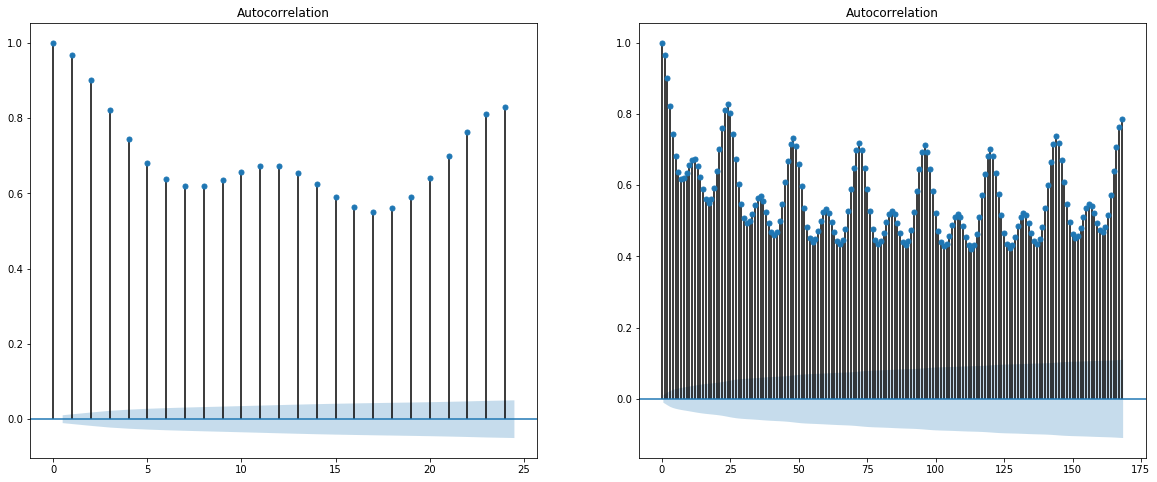

In [79]:
price_univar = data["price"]

fig, axs = plt.subplots(1,2, figsize=(20,8))

#we will plot the last 30 and 90 days
lags = [24, 24*7]

for ax, lag in zip(axs.flatten(), lags):
    plot_acf(price_univar, ax=ax, lags=lag)
plt.plot()

[]

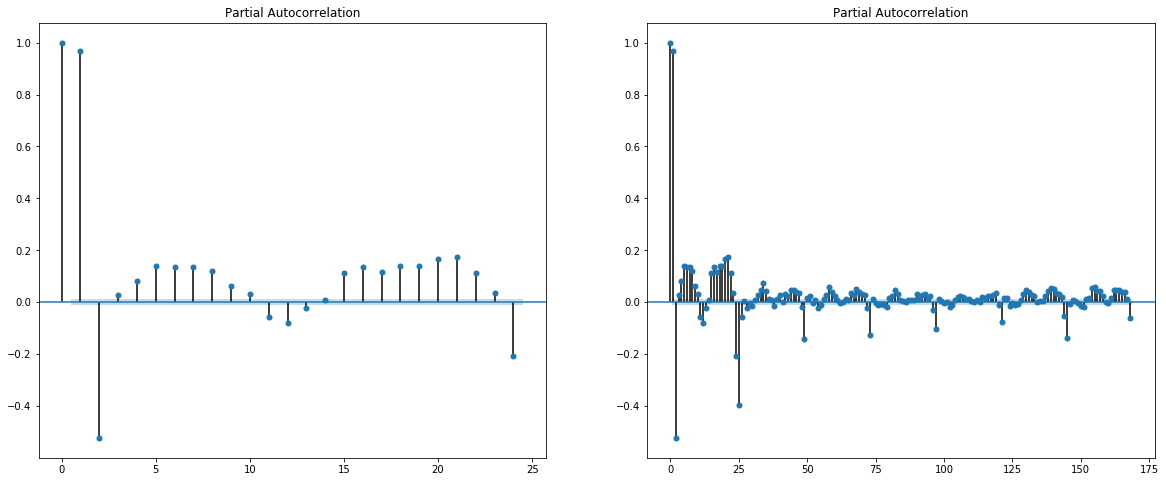

In [78]:
price_univar = data["price"]

fig, axs = plt.subplots(1,2, figsize=(20,8))

#we will plot the last 30 and 90 days
lags = [24, 24*7]

for ax, lag in zip(axs.flatten(), lags):
    plot_pacf(price_univar, ax=ax, lags=lag)
plt.plot()

[]

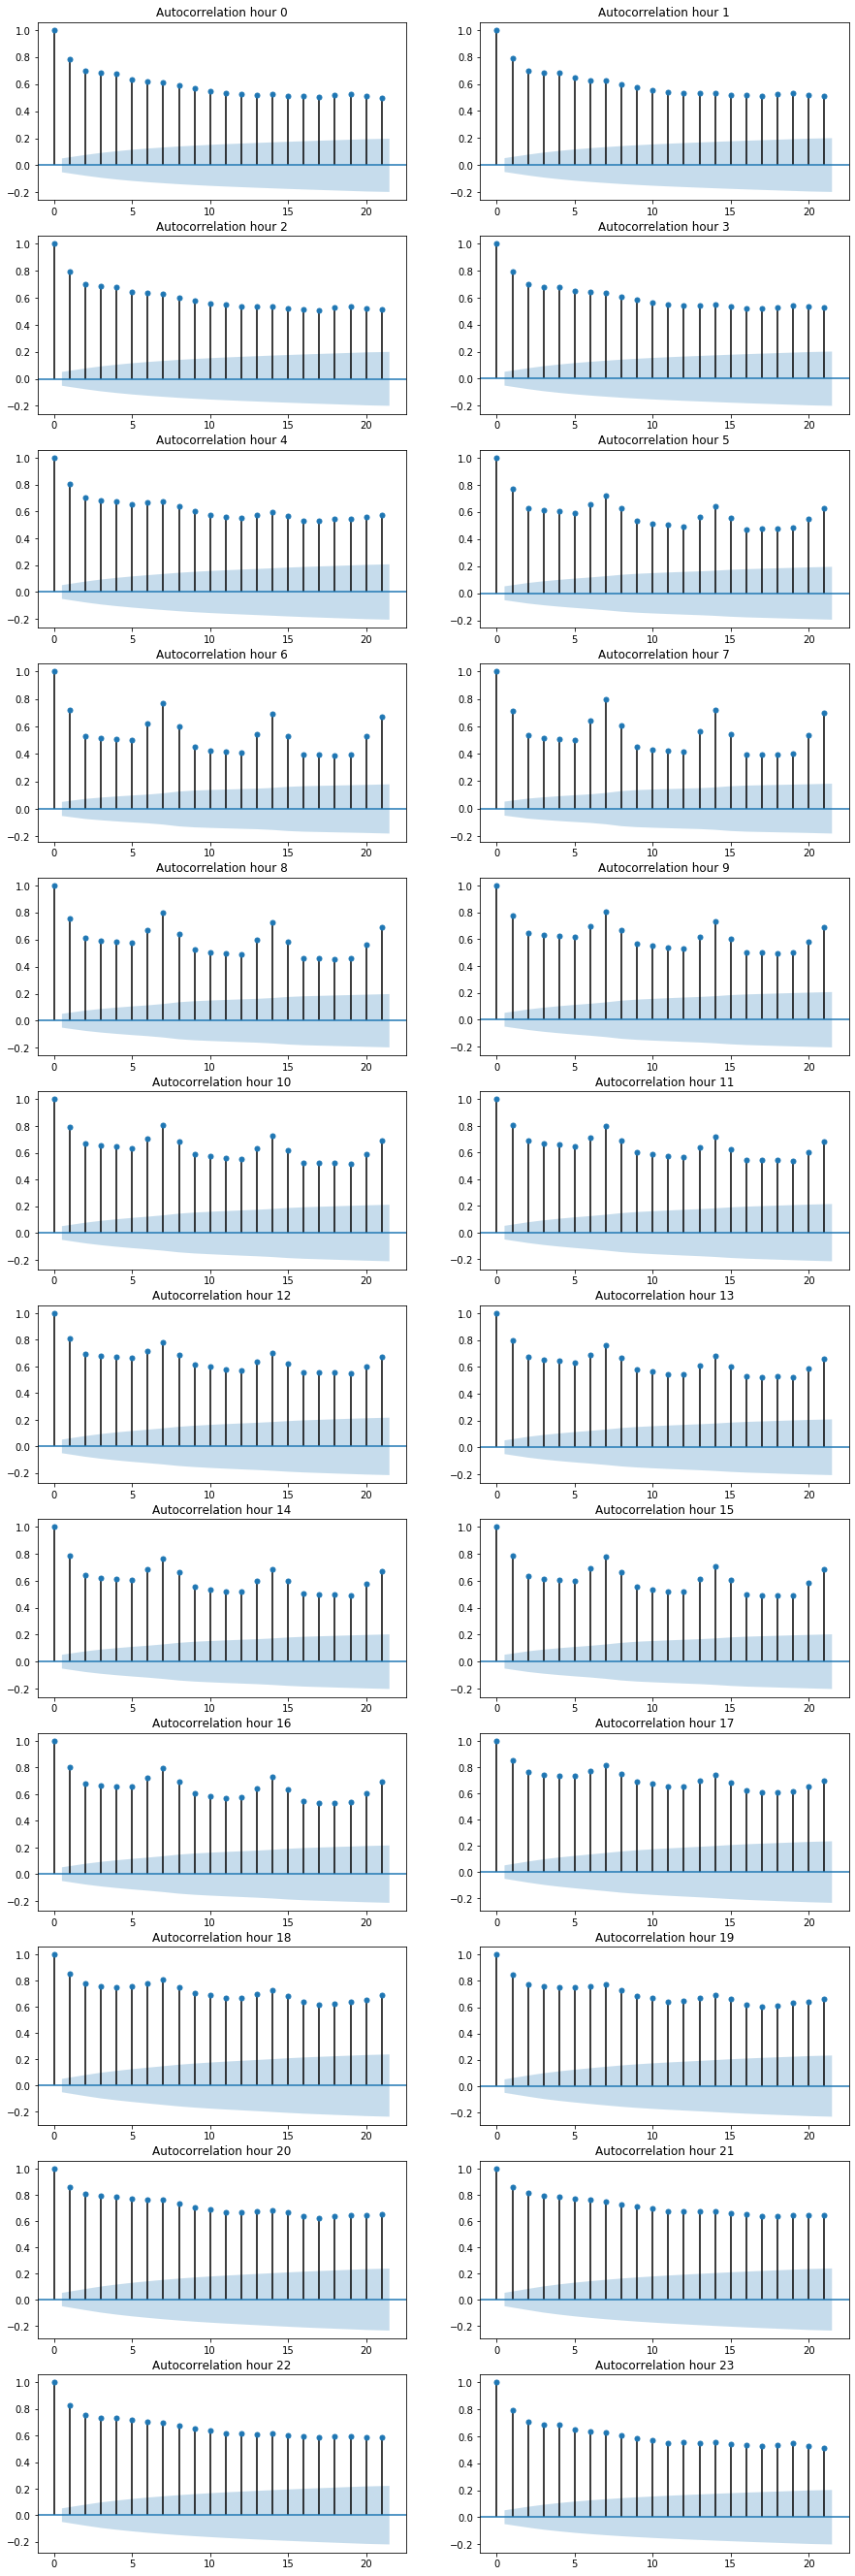

In [8]:
plots = len(day_price.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(day_price.columns, axs.flatten()):
        plot_acf(day_price.iloc[:,hour], ax=ax, lags=21)
        ax.set_title('Autocorrelation hour ' + str(hour))
plt.plot()

[]

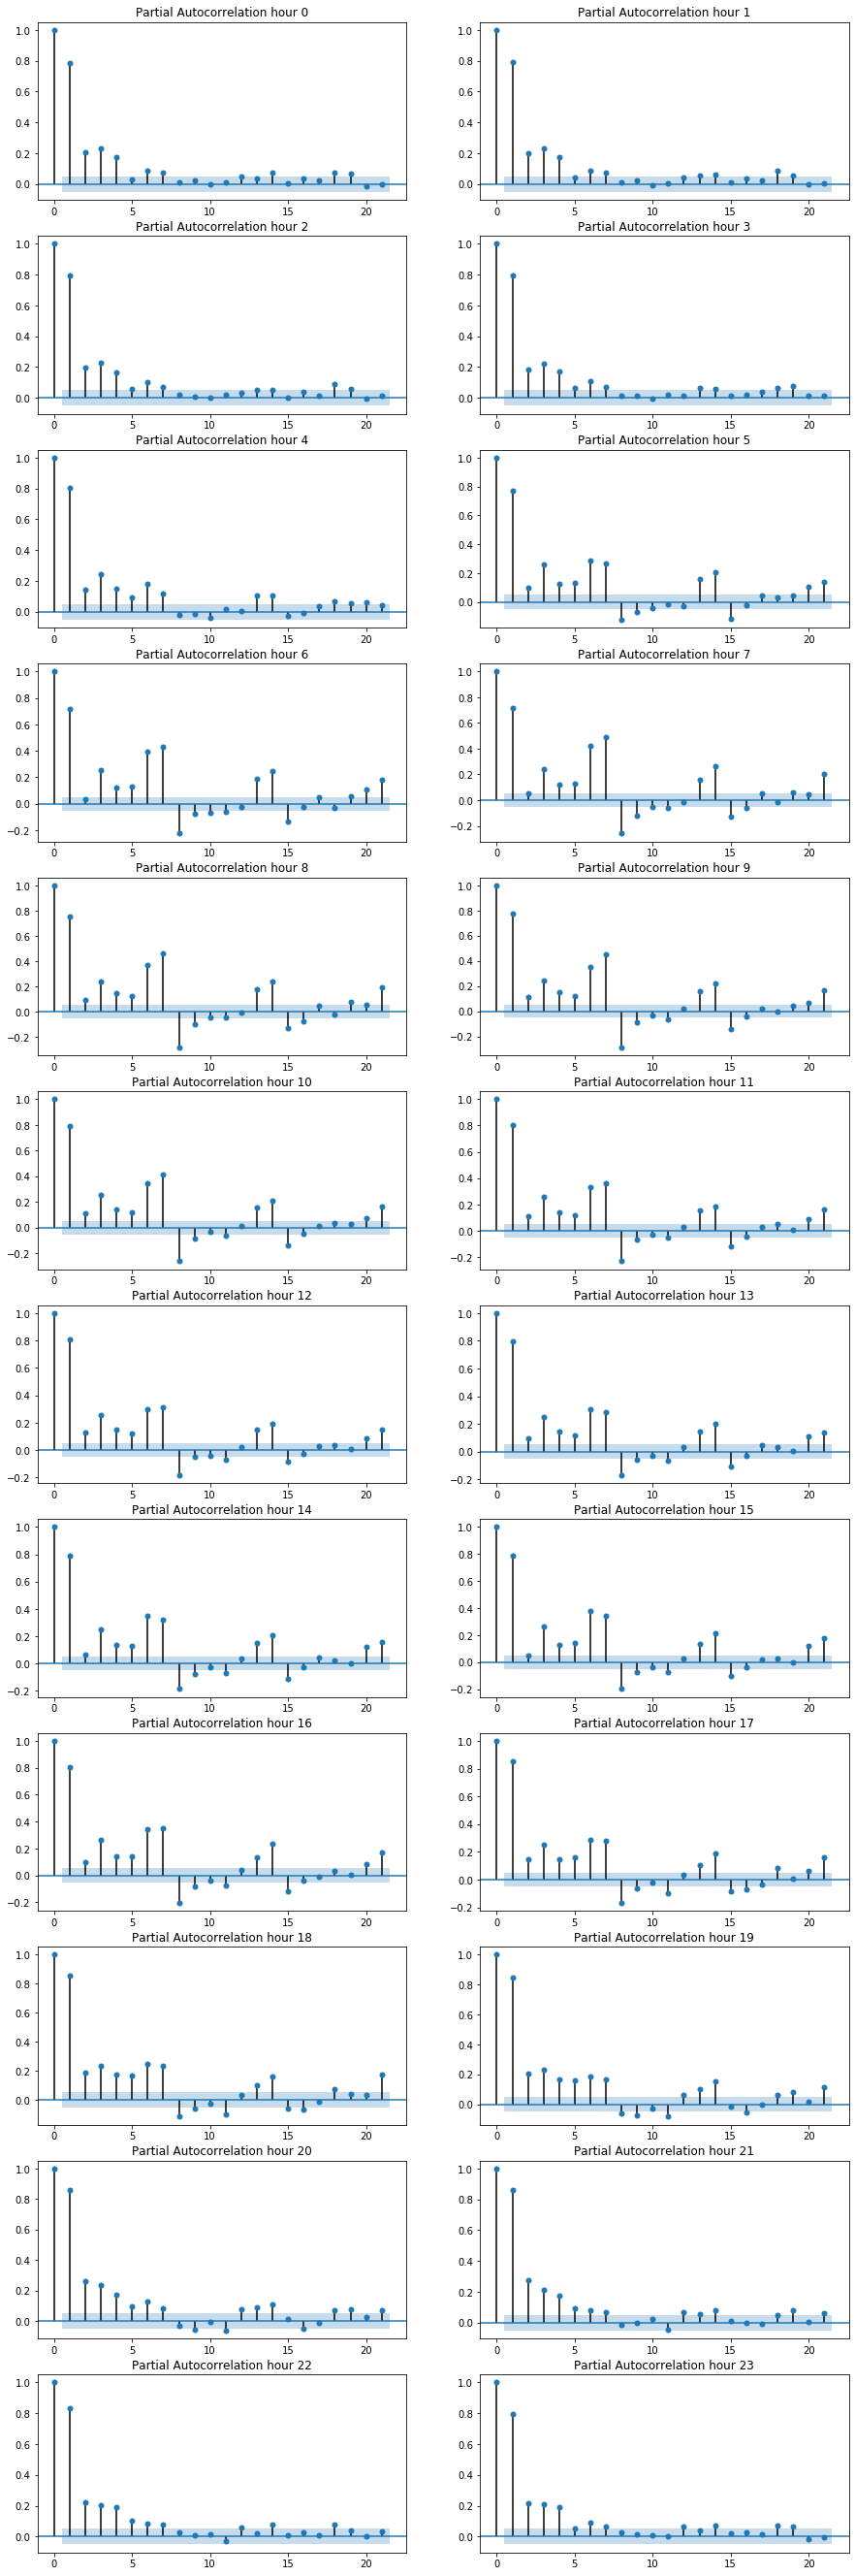

In [9]:
plots = len(day_price.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(day_price.columns, axs.flatten()):
        plot_pacf(day_price.iloc[:,hour], ax=ax, lags=21)
        ax.set_title('Partial Autocorrelation hour ' + str(hour))
plt.plot()

In [4]:
weather_data = to_utc_datetime(add_weather_data(get_price()))
weather_data = weather_data.drop(columns=["city_name"]).groupby(by=["time"]).mean()

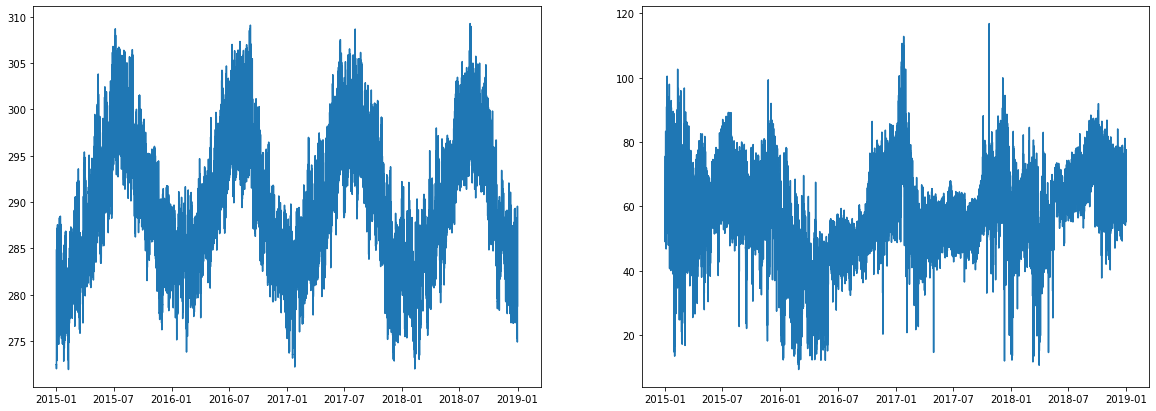

In [11]:
#fig, axs = plt.subplots(1,2, figsize=(20,8))
plot_columns = ["temp", "price"]
plots = len(plot_columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(20, 7))

for ax, column in zip(axs.flatten(), plot_columns):
    ax.plot(weather_data[column])
#plt.plot()

In [80]:
day_price.head()
# Korrelation als zusätzliche Features, z.B. 0 Uhr ist egal welcher Tag, während 12 Uhr gerne 7 Tage hätte -> Beide Werte nehmen und Korrelation als zusätzlich Parameter um zu vereinfachen was zu lernen ist

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,59.76,61.18,64.74,74.26,74.24,75.64,73.92,70.53,64.13,64.02
2015-01-02,58.46,54.70,54.91,53.07,54.23,58.22,67.55,70.33,71.26,75.86,...,71.24,70.64,72.85,82.55,83.33,83.23,79.06,76.20,71.75,66.82
2015-01-03,63.35,58.79,57.44,55.29,56.22,58.13,62.06,67.36,69.21,70.35,...,62.76,62.03,66.69,71.50,72.14,72.45,72.86,70.10,67.62,55.22
2015-01-04,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
2015-01-05,64.89,60.91,59.68,58.04,59.57,69.73,72.97,77.92,79.59,81.75,...,71.50,71.85,80.53,89.08,90.97,88.51,82.85,80.52,72.18,71.48


In [5]:
def add_price_x_hours_before(df, hours):
    df_n = df
    for hour in hours:
        df_n = df_n.join(df["price"].shift(periods=hour), lsuffix="", rsuffix="_%dh_before" % hour).dropna()
    return df_n
foo = add_price_x_hours_before(data, [1, 2, 24, 24*7])
foo.head()

,time,price,TSO_price_forecast,price_1h_before,price_2h_before,price_24h_before,price_168h_before
168,2015-01-07 23:00:00+00:00,73.73,49.00,75.07,78.15,67.24,65.41
169,2015-01-08 00:00:00+00:00,70.99,46.86,73.73,75.07,64.17,64.92
170,2015-01-08 01:00:00+00:00,68.30,45.68,70.99,73.73,62.12,64.48
171,2015-01-08 02:00:00+00:00,64.22,44.99,68.30,70.99,62.11,59.32
172,2015-01-08 03:00:00+00:00,63.53,44.81,64.22,68.30,60.05,56.04


In [74]:
#acf(price_univar, True, 24, fft=True)

,time,price,TSO_price_forecast
0,2014-12-31 23:00:00+00:00,65.41,50.10
1,2015-01-01 00:00:00+00:00,64.92,48.10
2,2015-01-01 01:00:00+00:00,64.48,47.33
3,2015-01-01 02:00:00+00:00,59.32,42.27
4,2015-01-01 03:00:00+00:00,56.04,38.41


In [4]:
def normalize_df(df):
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(df.values)
    data_normd = scaler.transform(df.values)
    #return as dataframe
    df = pd.DataFrame(data_normd, index=df.index, columns=df.columns)
    return df, scaler

day_price_normed, scaler = normalize_df(day_price)

In [5]:
target_year = 2018
train = day_price_normed.loc[day_price_normed.index.year != target_year]
test = day_price_normed.loc[day_price_normed.index.year == target_year]

In [6]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):
    """
    Modified based on content by Jason Brownlee from MachineLearningMastery.
    
    n_step - is the number of consecutive past steps from the target day to construct
    long_lag_step - is the size of the trailing lag beyond the n_steps. Ie. if n_steps is 3, and long_lag_step is 7 will return day -1, -2, -3, -7, -14 etc to max_step
    idx - is the starting index for the first slice
    multivari - true if the input data has multiple variable structure. false for univariate
    """
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y
#X,Y = split_sequences(day_price_normed.values, n_steps=21, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)
X_train, Y_train = split_sequences(train.values, n_steps=21, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)
X_test, Y_test = split_sequences(np.vstack([train.values[-60:], test.values]), n_steps=21, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

In [7]:
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(tf.keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [43]:
def crossval_testbench(X, y, n_crossvals, epochs=5, verbose=0):
    
    n_hours = X.shape[-1]
    n_features = X.shape[1]
    
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X, y):
        
        #initalize the lstm model
        lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
        #fit the model
        lstm_base.fit(X[train], y[train], epochs=epochs, verbose=verbose, shuffle=False)
        
        #make predictions
        predict = lstm_base.predict(X[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)
        
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    return predictions, actuals

#preds, actuals = crossval_testbench(X, Y, 2, epochs=150, verbose=1)

Train on 468 samples
Epoch 1/150
468/468 [==============================] - 2s 5ms/sample - loss: 116.2582
Epoch 2/150
468/468 [==============================] - 0s 731us/sample - loss: 58.3514
Epoch 3/150
468/468 [==============================] - 0s 699us/sample - loss: 52.1118
Epoch 4/150
468/468 [==============================] - 0s 920us/sample - loss: 51.0833
Epoch 5/150
468/468 [==============================] - 0s 764us/sample - loss: 45.6805
Epoch 6/150
468/468 [==============================] - 0s 646us/sample - loss: 35.4177
Epoch 7/150
468/468 [==============================] - 0s 768us/sample - loss: 27.7283
Epoch 8/150
468/468 [==============================] - 0s 721us/sample - loss: 23.0418
Epoch 9/150
468/468 [==============================] - 0s 656us/sample - loss: 21.0845
Epoch 10/150
468/468 [==============================] - 0s 769us/sample - loss: 18.3614
Epoch 11/150
468/468 [==============================] - 0s 699us/sample - loss: 20.2031
Epoch 12/150
468/468 

In [8]:
def train_lstm(X_train, Y_train, X_test, Y_test, epochs=5, verbose=0):
    n_hours = X_train.shape[-1]
    n_features = X_train.shape[1]
    lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
    #fit the model
    lstm_base.fit(X_train, Y_train, epochs=epochs, verbose=verbose, shuffle=False)
    #make predictions
    predict = lstm_base.predict(X_test, verbose=verbose)
    #inverse transform the predictions and actual values
    prediction = scaler.inverse_transform(predict)
    actual = scaler.inverse_transform(Y_test.copy())
    return prediction, actual

prediction, actual = train_lstm(X_train, Y_train, X_test, Y_test, epochs=350)

In [9]:
target_year = 2018
target_column = "price"
test_hourly = data.loc[data["time"].dt.year == target_year].copy(deep=True)

In [10]:
actual=actual.flatten()
prediction=prediction.flatten()
test_hourly=test_hourly.head(actual.__len__())

In [11]:
test_hourly["actual"] = actual
test_hourly["prediction"] = prediction

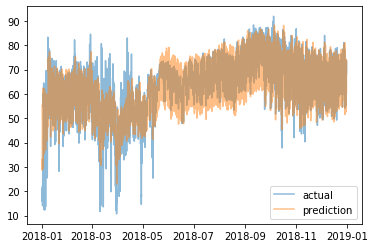

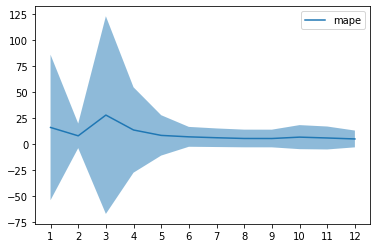

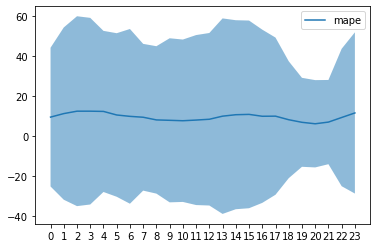

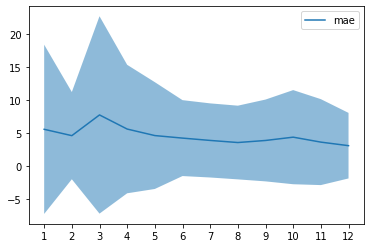

In [13]:
class TimeSeriesPlot:
    def __init__(self, df: pd.DataFrame, target_col:str, prediction_col:str, time_col:str="time"):
        self.df = df.copy(deep=True)
        self.target = target_col
        self.prediction = prediction_col
        self.time = time_col
        self.df['year'] = self.df[self.time].dt.year
        self.df['month'] = self.df[self.time].dt.month
        self.df['day'] = self.df[self.time].dt.day
        self.df['hours'] = self.df[self.time].dt.hour
        self.df["dayofweek"] = self.df[self.time].dt.weekday
        self.df["se"] = self.squared_error()
        self.df["mae"] = self.absolute_error()
        self.df["mape"] = self.absolute_percentage_error()
        
    def squared_error(self):
        return np.power(np.subtract(self.df[self.target], self.df[self.prediction]), 2)
    
    def absolute_error(self):
        return np.abs(np.subtract(self.df[self.target], self.df[self.prediction]))
    
    def absolute_percentage_error(self):
        return np.abs(np.divide(np.subtract(self.df[self.target], self.df[self.prediction]), self.df[self.target])) * 100
    
    def plot_rmse_by_time(self, time:str):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        mean = grouped["se"].mean()
        group_index = [str(index) for index in mean.index]
        plt.plot(group_index, np.sqrt(mean), label="rmse")
        return fig
        
    def plot_multiple(self, *cols: str):
        fig = plt.figure()
        for col in cols:
            plt.plot(self.df[self.time].values, self.df[col].values, alpha=0.5, label=col)
        plt.legend()
        plt.show()
        return fig
        
    def plot_target_by_time(self, time:str, *targets:str):
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        self.df.boxplot(column=[*targets], by=group_by_cols,
                        layout=(targets.__len__(), 1), rot=45, figsize=(50,40), grid=False)
        return plt.gcf()
        
    def plot_target_by_time_band(self, time:str, *targets:str, band:bool=True):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        for tar in targets:
            mean = grouped[tar].mean()
            std = grouped[tar].std()
            group_index = [str(index) for index in mean.index]
            plt.plot(group_index, mean, label=tar)
            if band:
                plt.fill_between(group_index, mean - 2*std, mean + 2*std, alpha=.5)
        plt.legend()
        return fig
        
        
foobar = TimeSeriesPlot(test_hourly, "actual", "prediction")
fig = foobar.plot_multiple("actual", "prediction")
fig.savefig("results/actual_prediction.png")
#bp = foobar.plot_target_by_time("%m%wd", "price", "prediction")
#bp.savefig("results/foo.png")
band = foobar.plot_target_by_time_band("%m", "mape", band=True)
#band.savefig("results/mape_per_month.png")
band = foobar.plot_target_by_time_band("%h", "mape", band=True)
#band.savefig("results/mape_per_hour.png")
band = foobar.plot_target_by_time_band("%m", "mae", band=True)
#band.savefig("results/mae_per_hour.png")
#rmse = foobar.plot_rmse_by_time("%m")
#band.savefig("results/band.png")

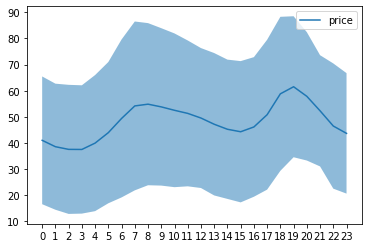

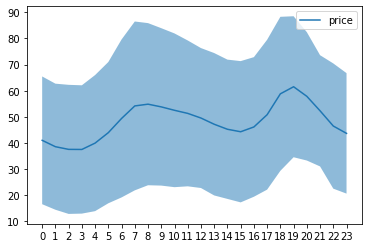

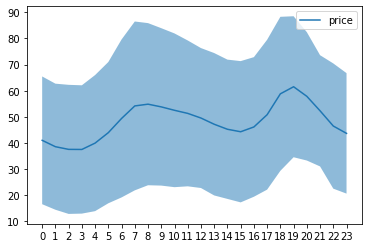

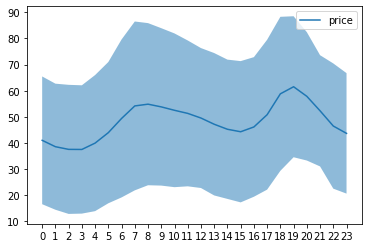

In [16]:
bar = TimeSeriesPlot(test_hourly.loc[test_hourly["time"].dt.month == 3], "actual", "prediction")

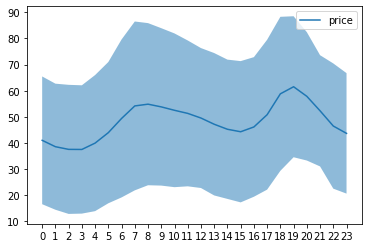

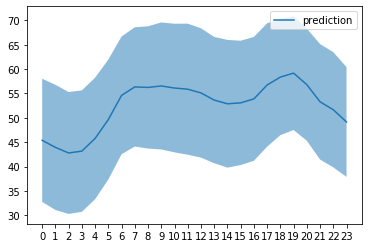

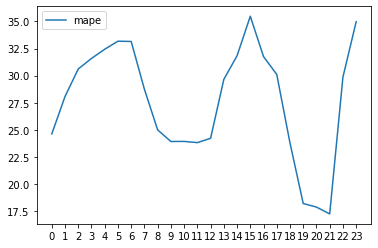

In [21]:
band = bar.plot_target_by_time_band("%h", "price")
band = bar.plot_target_by_time_band("%h", "prediction")
band = bar.plot_target_by_time_band("%h", "mape", band=False)

In [22]:
foo = TimeSeriesPlot(test_hourly.loc[test_hourly["time"].dt.month == 7], "actual", "prediction")

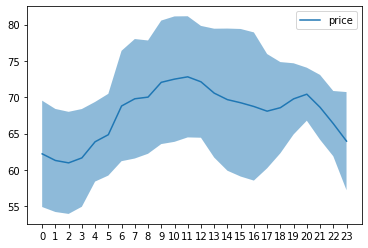

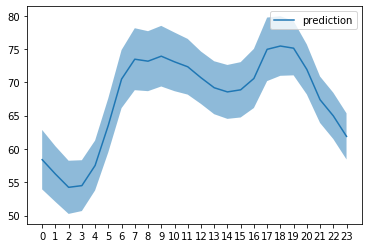

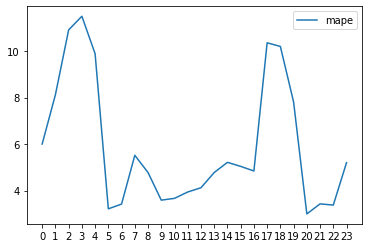

In [24]:
band = foo.plot_target_by_time_band("%h", "price")
band = foo.plot_target_by_time_band("%h", "prediction")
band = foo.plot_target_by_time_band("%h", "mape", band=False)

In [25]:
test_hourly.to_csv(os.path.join(DATA_PATH, "rnn_prediction.csv"))